In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

2024-01-30 17:18:27.037700: W external/org_tensorflow/tensorflow/tsl/platform/default/dso_loader.cc:67] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /datablock:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/conda/lib:/feynman/work/dphp/adematti/cosmo/cosmodesiconda/20230918-1.0.0/common/planck/code/plc_3.0/plc-3.1/lib:/opt/rhel-7.x86_64/gnu/hdf5/1.12.0/lib:/opt/rhel-7.x86_64/gnu4.9/openmpi/1.10.2/lib:/opt/rhel-7.x86_64/gnu/gsl/2.1/lib:/feynman/work/dphp/adematti/cosmodesiconda/20230918-1.0.0/aux/lib
2024-01-30 17:18:27.037733: W external/org_tensorflow/tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:264] failed call to cuInit: UNKNOWN ERROR (303)
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams['figure.dpi'] = 100

## Global parameters

In [26]:
# Mock parameters
boxsize = 2000
boxcenter = 0
nmesh = 1024
nbar = 0.01 #0.012 #0.003
cosmology = fiducial.AbacusSummitBase()
z = 1 #0.8 #1.175
bias = 1. #1.8

# Mocks
nmocks = 10

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

## Gaussian mocks to compare to model

In [27]:
output_dir = '/feynman/work/dphp/mp270220/outputs/mocks/lognormal/'

## Initialize Gaussian model

In [28]:
model = SplitCCFModel(redshift=z, cosmology=cosmology, bias=bias, nbar=nbar, damping=False)

/feynman/work/dphp/adematti/cosmodesiconda/20220713-1.0.0/code/cosmoprimo/main/lib/python3.9/site-packages/cosmoprimo/interpolator.py:353: ComplexWarning: Casting complex values to real discards the imaginary part
  x, y = (np.asarray(xx, dtype=dtype) for xx in (x, y))


In [29]:
model.sigma_RR

array([0.3084057])

In [30]:
delta0_g = bias
sigmaRR_g = np.sqrt(np.log(1 - bias + bias * np.exp(model.sigma_RR**2)))

In [31]:
sigmaRR_g

array([0.3084057])

## $\xi(s)$

In [64]:
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'

ells = [0]
nells = len(ells)

In [65]:
#name_temp = '{:d}_lognormal_mocks_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}'.format(nmocks, z, bias, boxsize, nmesh, nbar, cellsize, resampler)
#xi_results = np.load(output_dir+name_temp+'_2PCF.npy', allow_pickle=True)

In [66]:
from pycorr import TwoPointCorrelationFunction

# Abacus 2PCF
#xi_abacus = TwoPointCorrelationFunction.load(output_dir+'AbacusSummit_2Gpc_z0.800_2PCF.npy')
xi_abacus = TwoPointCorrelationFunction.load(output_dir+'AbacusSummit_2Gpc_z1.175_2PCF.npy')
#xi_abacus = TwoPointCorrelationFunction.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_2PCF.npy')
sep, xi_ells_abacus = xi_abacus.get_corr(ells=ells, return_sep=True)

[000111.31]  06-21 01:37  TwoPointEstimator            INFO     Loading /feynman/work/dphp/mp270220/outputs/correlation_functions/AbacusSummit_2Gpc_z1.175_2PCF.npy.


/feynman/work/dphp/adematti/cosmodesiconda/20220713-1.0.0/conda/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


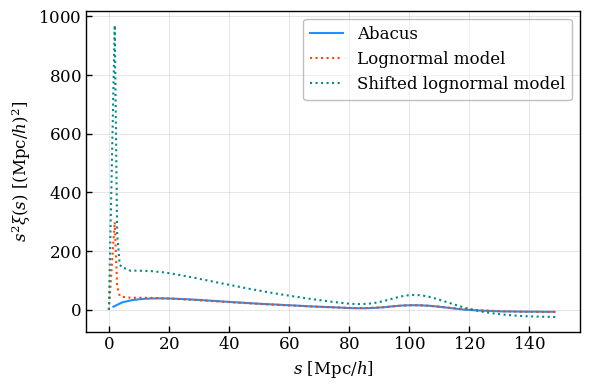

In [67]:
plt.rcParams["figure.figsize"] = (6, 4)

## Mocks
#mocks_xi_ells, cov = get_poles(xi_results, ells)
#std = np.array(np.array_split(np.diag(cov)**0.5, nells))/np.sqrt(nmocks)
#s, _, res = xi_results[0].get_corr(return_sep=True)
#tr = 2

## Model
model_xi = model.xi
shifted_lognormal_model = delta0_g**2 * (np.exp(model.xi) - 1)

for ill, ell in enumerate(ells):
    #y = s**2 * mocks_xi_ells[ill]
    #error = s**2 * std[ill]
    
    #plt.plot(s[tr:], y[tr:], label='Lognormal mocks') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
    plt.plot(sep, sep**2 * xi_ells_abacus[ill], label='Abacus')
    #plt.fill_between(s[tr:], y[tr:]-error[tr:], y[tr:]+error[tr:], alpha=0.4)
    plt.plot(model.sep, model.sep**2 * (np.exp(model_xi) - 1), label=r'Lognormal model', ls=':')
    plt.plot(model.sep, model.sep**2 * shifted_lognormal_model, label=r'Shifted lognormal model', ls=':')

plt.ylabel(r'$s^2 \xi(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.savefig('lognormalModel_AbacusParticles_2PCF.pdf', dpi=500)
plt.show()

## $\delta_R$

In [68]:
def friedrich_lognormal_model(delta, sigma, delta0):
    pdf_model = np.zeros_like(delta)
    pdf_model[delta > -delta0] = scipy.stats.lognorm.pdf(delta[delta > -delta0], sigma, -delta0, delta0 * np.exp(-sigma**2 / 2))
    return pdf_model

/feynman/work/dphp/adematti/cosmodesiconda/20220713-1.0.0/conda/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1904: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


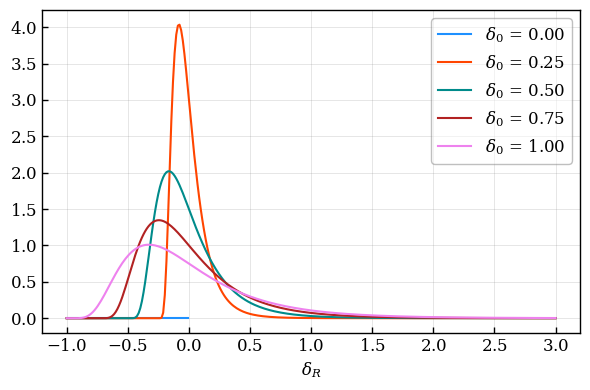

In [69]:
delta = np.linspace(-1, 3, 300)

for delta0 in np.linspace(0, 1, 5):
    pdf_model = friedrich_lognormal_model(delta, model.sigma_RR, delta0)
    plt.plot(delta, pdf_model, label=r'$\delta_0$ = {:.2f}'.format(delta0))
plt.xlabel(r'$\delta_R$')
plt.legend()
plt.show()

In [70]:
Nbar = nbar * 4/3 * np.pi * cellsize**3

In [71]:
Nbar

12.566370614359172

In [72]:
N_cic = np.load('/feynman/work/dphp/mp270220/outputs/'+'AbacusSummit_2Gpc_z1.175_density_cic_R{}Mpc.npy'.format(cellsize))
delta_cic = np.load('/feynman/work/dphp/mp270220/outputs/'+'AbacusSummit_2Gpc_z1.175_density_contrast_cic_R{}Mpc.npy'.format(cellsize))
#N_cic = np.load('/feynman/work/dphp/mp270220/outputs/'+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar{}_density_cic_R{}Mpc.npy'.format(nbar, cellsize))
#delta_cic = np.load('/feynman/work/dphp/mp270220/outputs/'+'AbacusSummit_2Gpc_z0.800_downsampled_particles_nbar{}_density_contrast_cic_R{}Mpc.npy'.format(nbar, cellsize))

In [73]:
def shot_noise_model(N, Nbar, delta0, sigma):
    delta = np.linspace(-delta0, 3, 100)
    pdf_deltag = friedrich_lognormal_model(delta, sigma, delta0)
    shotnoise = (Nbar * (1 + delta))**N / math.factorial(N) * np.exp(-Nbar * (1 + delta))
    pdf_N = np.trapz(pdf_deltag * shotnoise, delta)
    return pdf_N

In [74]:
np.mean(delta_cic)

0.0004036948421158056

In [75]:
sigma_measured = np.log(1 + np.sqrt(np.var(delta_cic)))

In [76]:
pdf_N = np.array([shot_noise_model(N, Nbar, delta0_g, sigma_measured) for N in range(150)])

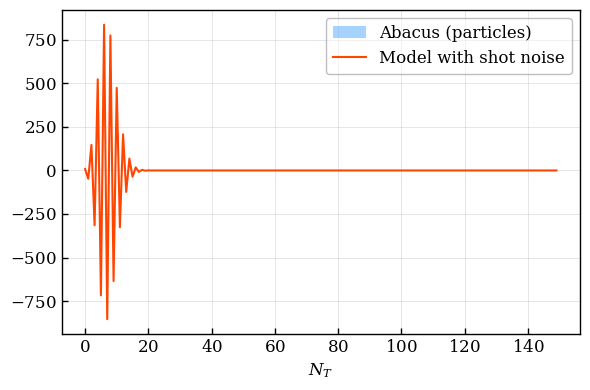

In [77]:
plt.hist(np.ravel(N_cic), density=True, bins=100, alpha=0.4, label='Abacus (particles)')
plt.plot(pdf_N, label='Model with shot noise')
plt.xlabel(r'$N_T$')
plt.legend()
plt.savefig('shotNoiseModel_vs_Abacus_particles_cic.pdf', dpi=500)
plt.show()

In [2]:
abacus_density = np.load('/feynman/work/dphp/mp270220/outputs/AbacusSummit_2Gpc_z1.175_cellsize{:d}_resampler{}_delta_R.npy'.format(cellsize, resampler))
#abacus_weighted_density = np.load('/feynman/work/dphp/mp270220/outputs/AbacusSummit_2Gpc_z1.175_cellsize{:d}_resampler{}_weighted_delta_R.npy'.format(cellsize, resampler))
#abacus_density = np.load('/feynman/work/dphp/mp270220/outputs/AbacusSummit_2Gpc_z0.800_downsampled_particles_cellsize{:d}_resampler{}_delta_R.npy'.format(cellsize, resampler))

NameError: name 'cellsize' is not defined

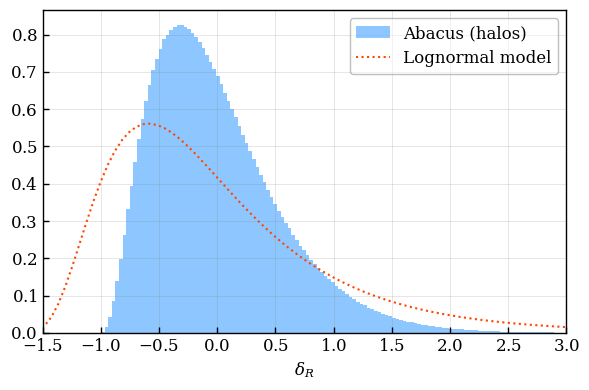

In [79]:
plt.rcParams["figure.figsize"] = (6, 4)

output_dir = '/feynman/work/dphp/mp270220/outputs/mocks/lognormal/'
name_temp = '{:d}_lognormal_mocks_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}'.format(nmocks, z, bias, boxsize, nmesh, nbar, cellsize, resampler)

delta = np.linspace(-3, 3, 100)

## Mocks
#densities = np.concatenate(np.load(output_dir+name_temp+'_delta_R.npy', allow_pickle = True))

# Lognormal model
mu = - model.sigma_RR**2/2
lognormal_model = friedrich_lognormal_model(delta, model.sigma_RR, delta0_g) #scipy.stats.lognorm.pdf(1 + delta, model.sigma_RR, 0, np.exp(mu))

#plt.hist(np.ravel(densities), bins=20000, density=True, alpha=0.5, label='10 lognormal mocks')
plt.hist(abacus_density, bins=200, density=True, alpha=0.5, label='Abacus (halos)')
#plt.hist(abacus_weighted_density, bins=800, density=True, alpha=0.5, label='Abacus (with weights)')
plt.plot(delta, lognormal_model, label='Lognormal model', ls=':')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1.5, 3))
plt.legend()
plt.savefig('lognormalModel_vs_Abacus_delta_R.pdf', dpi=500)
plt.show()

In [16]:
## shot noise
fourier_kernel = model.smoothing_kernel_3D
norm_fourier_kernel = fourier_kernel / model.boxsize**3
real_space_kernel = norm_fourier_kernel.c2r()
real_space_kernel.value = np.real(real_space_kernel.value)
w2 = integrate_pmesh_field(real_space_kernel**2)

KeyboardInterrupt: 

In [23]:
shotnoise = w2 / model.nbar

In [32]:
shotnoise

0.02037610855154608

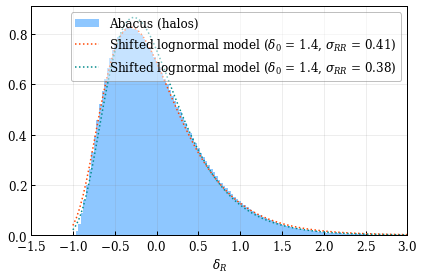

In [37]:
plt.rcParams["figure.figsize"] = (6, 4)

delta = np.linspace(-1, 3, 100)
delta0 = 1.4
delta0_without_shotnoise = 1.4
sigmaRR_adj = 0.8 * model.sigma_RR[0]
sigmaRR_without_shotnoise = np.sqrt(sigmaRR_adj**2 - shotnoise)
shifted_lognormal_model = friedrich_lognormal_model(delta, sigmaRR_adj, delta0)
shifted_lognormal_model_without_shotnoise = friedrich_lognormal_model(delta, sigmaRR_without_shotnoise, delta0_without_shotnoise)
    
plt.hist(abacus_density, bins=200, density=True, alpha=0.5, label='Abacus (halos)')
plt.plot(delta, shifted_lognormal_model, label=r'Shifted lognormal model ($\delta_0$ = {}, $\sigma_{{RR}}$ = {:.2f})'.format(delta0, sigmaRR_adj), ls=':')
plt.plot(delta, shifted_lognormal_model_without_shotnoise, label=r'Shifted lognormal model ($\delta_0$ = {}, $\sigma_{{RR}}$ = {:.2f})'.format(delta0_without_shotnoise, sigmaRR_without_shotnoise), ls=':')
plt.xlabel(r'$\delta_R$')
plt.xlim((-1.5, 3))
plt.legend()
plt.savefig('shiftedLognormalModel_vs_Abacus_delta_R.pdf', dpi=500)
plt.show()

In [ ]:
from pandas import qcut
test, th_bins = qcut(densities, 3, retbins=True)

NameError: name 'densities' is not defined

In [ ]:
th_bins

In [13]:
th_bins = scipy.stats.lognorm.ppf([0, 1./3, 2./3, 1], np.sqrt(variance), -1, np.exp(mu))

In [14]:
th_bins

array([-1.        , -0.18346272,  0.09637895,         inf])

In [37]:
np.mean(np.ravel(densities))

-7.575051711146812e-05

In [36]:
np.mean(model_density_no_shot_noise)

0.16499999999983125

In [30]:
np.var(densities)

0.24094721822073553

In [61]:
np.exp(model.sigma_RR**2) - 1

array([0.19849579])

## $\xi_{R}(s)$ and $\xi_{Y, R}(s)$

In [32]:
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'

ells = [0]
nells = len(ells)

In [33]:
xi_R_result = list()

for batch_index in range(10):
    batch_size = 10
    name_temp = 'lognormalMock{:d}_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}'.format(batch_index, z, bias, boxsize, nmesh, nbar, cellsize, resampler)
    batch_results = np.load(output_dir+name_temp+'_xi_R.npy', allow_pickle=True)
    for batch in batch_results:
        xi_R_result.append(batch)

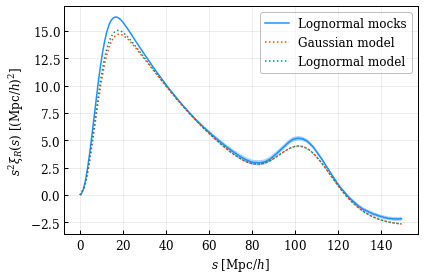

In [34]:
plt.rcParams["figure.figsize"] = (6, 4)

## Mocks
mocks_xi_ells, cov = get_poles(xi_R_result, ells)
std = np.array(np.array_split(np.diag(cov)**0.5, nells))/np.sqrt(10)
s, _, res = xi_R_result[0].get_corr(return_sep=True)

## Model
model_xi_R = model.xi_R

for ill, ell in enumerate(ells):
    y = s**2 * mocks_xi_ells[ill]
    error = s**2 * std[ill]
    xi_Y_R = np.log(1 + mocks_xi_ells[ill])

    plt.plot(s, y, label='Lognormal mocks') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
    plt.fill_between(s, y-error, y+error, alpha=0.4)
    #plt.plot(s, s**2 * xi_Y_R, label=r'$\xi_{Y, R}$ (mocks)', ls=':')
    plt.plot(model.sep, model.sep**2 * model_xi_R, label=r'Gaussian model', ls=':')
    plt.plot(model.sep, model.sep**2 * (np.exp(model_xi_R) - 1), label=r'Lognormal model', ls=':')

plt.ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
#plt.savefig('lognormalModel_2PCF.pdf', dpi=500)
plt.show()

## Lognormal model for density splits

In [35]:
nsplits = 3
randoms_size = 4
th_bins = np.array([-1., -0.16672411, 0.08937877, np.inf]) #scipy.stats.lognorm.ppf([0, 1./3, 2./3, 1], np.sqrt(variance), -1, np.exp(mu)) # np.array([-1., -0.16672411, 0.08937877, np.inf])
#th_bins = np.array([-np.inf, np.inf])

In [36]:
sigma = np.sqrt(np.exp(model.sigma**2) - 1)
sigmaRR = np.sqrt(np.exp(model.sigma_RR**2) - 1)
sigmaR = np.sqrt(np.exp(model.sigma_R**2) - 1)

In [37]:
def compute_main_term(delta):
    if math.isfinite(delta):
        a = scipy.special.erf((np.log((1 + delta)) - model.xi_R + model.sigma_RR**2/2) / (np.sqrt(2) * model.sigma_RR))
        b = scipy.special.erf((np.log((1 + delta)) + model.sigma_RR**2/2) / (np.sqrt(2) * model.sigma_RR))
    else:
        if delta > 0:
            a = np.full_like(model.xi_R, 1)
            b = np.full_like(model.xi_R, 1)
        if delta < 0:
            a = np.full_like(model.xi_R, -1)
            b = np.full_like(model.xi_R, -1)
    return a, b

In [38]:
dsplits = list()

for i in range(len(th_bins)-1):
    d1 = th_bins[i]
    d2 = th_bins[i+1]
    a1, b1 = compute_main_term(d1)
    a2, b2 = compute_main_term(d2)
    main_term = (a2 - a1) / (b2 - b1)
    dsplits.append(main_term - 1)

/tmp/ipykernel_3241312/2670654368.py:3: RuntimeWarning: divide by zero encountered in log
  a = scipy.special.erf((np.log((1 + delta)) - model.xi_R + model.sigma_RR**2/2) / (np.sqrt(2) * model.sigma_RR))
/tmp/ipykernel_3241312/2670654368.py:4: RuntimeWarning: divide by zero encountered in log
  b = scipy.special.erf((np.log((1 + delta)) + model.sigma_RR**2/2) / (np.sqrt(2) * model.sigma_RR))


In [39]:
colors = ['firebrick', 'violet', 'olivedrab']

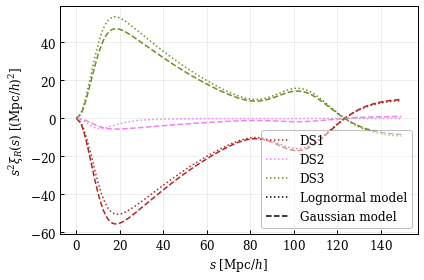

In [40]:
plt.rcParams["figure.figsize"] = (6, 4)

for i in range(nsplits):
    plt.plot(model.sep, model.sep**2 * dsplits[i], label=r'DS{}'.format(i+1), ls=':', color=colors[i])
    plt.plot(model.sep, model.sep**2 * model.ccf_randoms_tracers(density_bins=th_bins)[i], ls='--', color=colors[i])
plt.plot([], [], ls=':', label='Lognormal model', color='black')
plt.plot([], [], ls='--', label='Gaussian model', color='black')

plt.ylabel(r'$s^2 \xi_{R}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.savefig('lognormalModel_vs_gaussianModel_3DS.pdf', dpi=500)
plt.show()

In [41]:
results = list()

for batch_index in range(10):
    name_temp = 'lognormal_mock{:d}_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler{}_{:d}splits_randoms_size{:d}'.format(batch_index, z, bias, boxsize, nmesh, nbar, cellsize, resampler, nsplits, randoms_size)
    batch_results = np.load(output_dir+name_temp+'_RH_CCF.npy', allow_pickle=True)
    results.append(batch_results[0])

In [42]:
mocks_split_xi_rh, cov_rh = get_split_poles(results, ells=ells, nsplits=nsplits)
std_rh = np.array_split(np.array(np.array_split(np.diag(cov_rh)**0.5, nells)), nsplits, axis=1)/np.sqrt(nmocks)

In [20]:
# Abacus density splits
split_xi_abacus = np.load(output_dir+'AbacusSummit_2Gpc_z0.800_downsampled_particles_cellsize{:d}_resampler{}_{:d}splits_randoms_size{:d}'.format(cellsize, resampler, nsplits, randoms_size)+'_RH_CCF.npy', allow_pickle=True)

In [21]:
split_xi_abacus = split_xi_abacus.item()['rh']

In [22]:
split_xi_ells_abacus = [split_xi_abacus[ds].get_corr(ells=ells) for ds in range(nsplits)]

In [23]:
sep, _ = split_xi_abacus[0].get_corr(ells=ells, return_sep=True)

In [43]:
s, _, res = results[0][0].get_corr(return_sep=True)

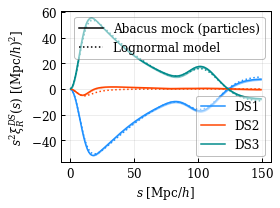

In [49]:
for ill, ell in enumerate(ells):
    for ds in range(nsplits):
        y = s**2 * mocks_split_xi_rh[ds][ill]
        error = s**2 * std_rh[ds][ill]

        plt.plot(s, y, color=colors[ds])
        plt.fill_between(s, y-error, y+error, alpha=0.4, color=colors[ds])
        #plt.plot(sep, sep**2 * split_xi_ells_abacus[ds][0], label=r'DS{}'.format(ds+1), ls='-', color=colors[ds])
        plt.plot(model.sep, model.sep**2 * dsplits[ds], label=r'DS{}'.format(ds+1), ls=':', color=colors[ds])
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')

lines = list()
for ds in range(nsplits):
    line, = plt.plot([], [], label=r'DS{}'.format(ds+1), color=colors[ds])
    lines.append(line)
#line2, = plt.plot([], [], ls='-', color='black', label='Lognormal mocks')
line2, = plt.plot([], [], ls='-', color='black', label='Abacus mock (particles)')
line3, = plt.plot([], [], ls=':', color='black', label='Lognormal model')

first_legend = plt.legend(handles=lines, loc='lower right')
ax = plt.gca().add_artist(first_legend)
plt.legend(handles=[line2, line3], loc='upper right')

plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.ylabel(r'$s^2 \xi_{R}^{DS}(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.savefig('AbacusMock_vs_lognormalModel_densitysplitsRH_spotlight.png', dpi=500)
plt.show()